In [1]:
import gym 
import random
import matplotlib.pyplot as plt

In [2]:
# open env from gym

env = gym.make("ALE/SpaceInvaders-v5")

height, width, channels = env.observation_space.shape
actions = env.action_space.n


A.L.E: Arcade Learning Environment (version 0.7.5+db37282)
[Powered by Stella]


In [29]:
height

210

In [30]:
width

160

# Testeo del enviroment

In [46]:
episodes = 5
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0 
    
    while not done:
        env.render()
        action = random.choice([0,1])
        n_state, reward, done, info = env.step(action)
        score+=reward
    print('Episode:{} Score:{}'.format(episode, score))
    
env.close()

Episode:1 Score:-200.0
Episode:2 Score:-200.0
Episode:3 Score:-200.0
Episode:4 Score:-200.0
Episode:5 Score:-200.0


# Creando la red neuronal

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten,Convolution2D
from tensorflow.keras.optimizers import Adam



2022-11-27 13:10:07.725861: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-27 13:10:08.892228: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-27 13:10:10.990896: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/alvaro/anaconda3/envs/tf-wsl/lib/python3.8/site-packages/cv2/../../lib64:/usr/local/cuda/include:/usr/local/cuda/lib64:/home/alvaro/robotics_ws/devel/lib:/opt/ros/noetic/lib:/usr/local/cuda/extras/CUPTI/lib

In [26]:
del model

# NN mk2

In [27]:
def build_model(height, width, channels, actions):

    model = tf.keras.Sequential()
    model.add(Convolution2D(32, (8,8), strides=(4,4), activation='relu', input_shape=(3,height, width, channels)))
    model.add(Convolution2D(64, (4,4), strides=(2,2), activation='relu'))
    model.add(Flatten())
    model.add(Dense(216, activation='relu'))     
    model.add(Dense(actions, activation='linear'))
    return model

In [28]:
model = build_model(height, width, channels, actions)


In [29]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 3, 51, 39, 32)     6176      
                                                                 
 conv2d_7 (Conv2D)           (None, 3, 24, 18, 64)     32832     
                                                                 
 flatten_3 (Flatten)         (None, 82944)             0         
                                                                 
 dense_12 (Dense)            (None, 216)               17916120  
                                                                 
 dense_13 (Dense)            (None, 6)                 1302      
                                                                 
Total params: 17,956,430
Trainable params: 17,956,430
Non-trainable params: 0
_________________________________________________________________


# Agente

In [8]:
from rl.agents import DQNAgent
from rl.policy import EpsGreedyQPolicy,LinearAnnealedPolicy
from rl.memory import SequentialMemory
from tensorflow.python.framework.ops import disable_eager_execution

In [61]:
def build_agent(model, actions):
    # policy = BoltzmannQPolicy()
    policy=EpsGreedyQPolicy()
    memory = SequentialMemory(limit=100000, window_length=1)
   ##Dueling DQN with parameters
    
    dqn = DQNAgent(model=model, memory=memory, policy=policy, 
    nb_actions=actions, 
   # processor=processor,
    nb_steps_warmup=100,
    gamma=.99, 
    target_model_update=100,
    #train_interval=4,
    #delta_clip=1.,
    enable_dueling_network=True,
    dueling_type='avg'
)
    return dqn



In [9]:
def build_agent(model, actions):
    policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps', value_max=1., value_min=.1, value_test=.2, nb_steps=10000)
    memory = SequentialMemory(limit=1000, window_length=3)
    dqn = DQNAgent(model=model, memory=memory, policy=policy,
                  enable_dueling_network=True, dueling_type='avg', 
                   nb_actions=actions, nb_steps_warmup=1000
                  )
    return dqn

In [15]:
dqn = build_agent(model, actions)

# Mi VRAM solo rinde hasta 10k steps :ccccccc

In [16]:
dqn.compile(Adam(lr=1e-3))

/home/alvaro/anaconda3/envs/tf-wsl/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [18]:


dqn.fit(env, nb_steps=10000, visualize=False, verbose=2)


Training for 10000 steps ...


/home/alvaro/anaconda3/envs/tf-wsl/lib/python3.8/site-packages/keras/engine/training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2022-11-27 13:19:00.247066: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2022-11-27 13:19:03.667157: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


  380/10000: episode: 1, duration: 19.031s, episode steps: 380, steps per second:  20, episode reward: 20.000, mean reward:  0.053 [ 0.000, 10.000], mean action: 2.482 [0.000, 5.000],  loss: --, mean_q: --, mean_eps: --
  668/10000: episode: 2, duration: 6.565s, episode steps: 288, steps per second:  44, episode reward: 45.000, mean reward:  0.156 [ 0.000, 15.000], mean action: 2.399 [0.000, 5.000],  loss: --, mean_q: --, mean_eps: --
  966/10000: episode: 3, duration: 6.047s, episode steps: 298, steps per second:  49, episode reward: 50.000, mean reward:  0.168 [ 0.000, 20.000], mean action: 2.648 [0.000, 5.000],  loss: --, mean_q: --, mean_eps: --


/home/alvaro/anaconda3/envs/tf-wsl/lib/python3.8/site-packages/keras/engine/training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


 1352/10000: episode: 4, duration: 288.526s, episode steps: 386, steps per second:   1, episode reward: 105.000, mean reward:  0.272 [ 0.000, 30.000], mean action: 2.622 [0.000, 5.000],  loss: 1.473581, mean_q: 1.974715, mean_eps: 0.894160
 2004/10000: episode: 5, duration: 512.881s, episode steps: 652, steps per second:   1, episode reward: 190.000, mean reward:  0.291 [ 0.000, 30.000], mean action: 2.416 [0.000, 5.000],  loss: 1.763360, mean_q: 1.405423, mean_eps: 0.849025
 2400/10000: episode: 6, duration: 310.940s, episode steps: 396, steps per second:   1, episode reward: 105.000, mean reward:  0.265 [ 0.000, 30.000], mean action: 2.563 [0.000, 5.000],  loss: 2.047386, mean_q: 0.495461, mean_eps: 0.801865
 3056/10000: episode: 7, duration: 508.077s, episode steps: 656, steps per second:   1, episode reward: 260.000, mean reward:  0.396 [ 0.000, 30.000], mean action: 2.780 [0.000, 5.000],  loss: 2.466645, mean_q: 0.495298, mean_eps: 0.754525
 3452/10000: episode: 8, duration: 307.6

#  Probar la red neuronal

In [23]:
scores = dqn.test(env, nb_episodes=10, visualize=False)
print(np.mean(scores.history['episode_reward']))

Testing for 10 episodes ...
Episode 1: reward: 180.000, steps: 611
Episode 2: reward: 460.000, steps: 765
Episode 3: reward: 110.000, steps: 505
Episode 4: reward: 260.000, steps: 741
Episode 5: reward: 180.000, steps: 611
Episode 6: reward: 350.000, steps: 1090
Episode 7: reward: 110.000, steps: 505
Episode 8: reward: 180.000, steps: 608
Episode 9: reward: 110.000, steps: 512
Episode 10: reward: 180.000, steps: 653
212.0


In [75]:
env.close()

# Guardar y cargar pesos

In [25]:
dqn.save_weights('space_invaders_mk2_20k.h5f', overwrite=True)

In [17]:
dqn.load_weights('space_invaders_mk2_20k.h5f')

# Ploteo de rewards

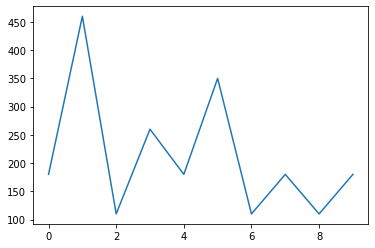

In [24]:
plt.plot(scores.history['episode_reward'])

plt.show()
